## Fairness Audit and Debiasing

Imports & Setup

In [69]:
#Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, os
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, equalized_odds_difference

from collections import defaultdict



Load Validation Data and Models

In [70]:
# Load Validation Data and Models
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

X_raw = df.drop("is_recid", axis=1)
y = df["is_recid"]
X_transformed = pipeline.transform(X_raw)

# Select modeling features
selected_features = ["age", "sex", "juv_misd_count", "juv_fel_count", "priors_count", "c_charge_degree", "c_charge_desc"]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Reproduce splits
X_trainval, X_test, y_trainval, y_test, X_raw_trainval, X_raw_test = train_test_split(
    X_selected, y, X_raw, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val, X_raw_train, X_raw_val = train_test_split(
    X_trainval, y_trainval, X_raw_trainval, test_size=0.176, stratify=y_trainval, random_state=42)

# Load finetuned models
logreg = joblib.load("../models/tuned/logistic_regression_finetuned.pkl")
adaboost = joblib.load("../models/tuned/adaboost_finetuned.pkl")
neural_net = joblib.load("../models/tuned/neural_network_finetuned.pkl")


Define Fairness Function for Equalized Odds

In [71]:
# Define Fairness Function for Equalized Odds

def run_equalized_odds(model, X_val, y_val, sensitive_features, model_name):
    postproc = ThresholdOptimizer(
        estimator=model,
        constraints="equalized_odds",
        prefit=True
    )
    postproc.fit(X_val, y_val, sensitive_features=sensitive_features)
    y_pred_fair = postproc.predict(X_val, sensitive_features=sensitive_features)

    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "f1": f1_score
    }

    mf = MetricFrame(metrics=metrics, y_true=y_val, y_pred=y_pred_fair, sensitive_features=sensitive_features)
    eq_odds_diff = equalized_odds_difference(y_val, y_pred_fair, sensitive_features=sensitive_features)

    return mf, eq_odds_diff


Run Multiple Times for Averaging

In [72]:
#Run Multiple Times for Averaging
n_runs = 5
results = defaultdict(list)

for i in range(n_runs):
    sensitive_attr = X_raw_val["sex"].values  # Binary: 0 = Female, 1 = Male

    mf_logreg, eq_logreg = run_equalized_odds(logreg, X_val, y_val, sensitive_attr, "Logistic Regression")
    mf_adaboost, eq_adaboost = run_equalized_odds(adaboost, X_val, y_val, sensitive_attr, "AdaBoost")
    mf_nn, eq_nn = run_equalized_odds(neural_net, X_val, y_val, sensitive_attr, "Neural Network")

    for name, mf, eq in [
        ("Logistic Regression", mf_logreg, eq_logreg),
        ("AdaBoost", mf_adaboost, eq_adaboost),
        ("Neural Network", mf_nn, eq_nn)
    ]:
        for group in ["Female", "Male"]:
            results[(name, group, "accuracy")].append(mf.by_group.loc[group, "accuracy"])
            results[(name, group, "precision")].append(mf.by_group.loc[group, "precision"])
            results[(name, group, "recall")].append(mf.by_group.loc[group, "recall"])
            results[(name, group, "f1")].append(mf.by_group.loc[group, "f1"])
        results[(name, "equalized_odds_diff")].append(eq)


Store Averaged Fairness Results

In [73]:
# Store Averaged Fairness Results
summary_rows = []
for name in ["Logistic Regression", "AdaBoost", "Neural Network"]:
    row = {
        "Model": name,
        "Equalized Odds Difference": round(np.mean(results[(name, "equalized_odds_diff")]), 4)
    }
    for group in ["Female", "Male"]:
        for metric in ["accuracy", "precision", "recall", "f1"]:
            mean_val = np.mean(results[(name, group, metric)])
            row[f"{metric.capitalize()} ({group})"] = round(mean_val, 4)
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
os.makedirs("../reports/04_fairness", exist_ok=True)
summary_df.to_csv("../reports/04_fairness/equalized_odds_avg_results.csv", index=False)
summary_df


,Model,Equalized Odds Difference,Accuracy (Female),Precision (Female),Recall (Female),F1 (Female),Accuracy (Male),Precision (Male),Recall (Male),F1 (Male)
0,Logistic Regression,0.0355,0.7908,0.6006,0.6100,0.6050,0.7639,0.6923,0.5973,0.6413
1,AdaBoost,0.0355,0.7974,0.6085,0.6450,0.6259,0.7728,0.7010,0.6224,0.6594
2,Neural Network,0.0434,0.8000,0.6005,0.7175,0.6536,0.7712,0.6711,0.6911,0.6809


Visualization

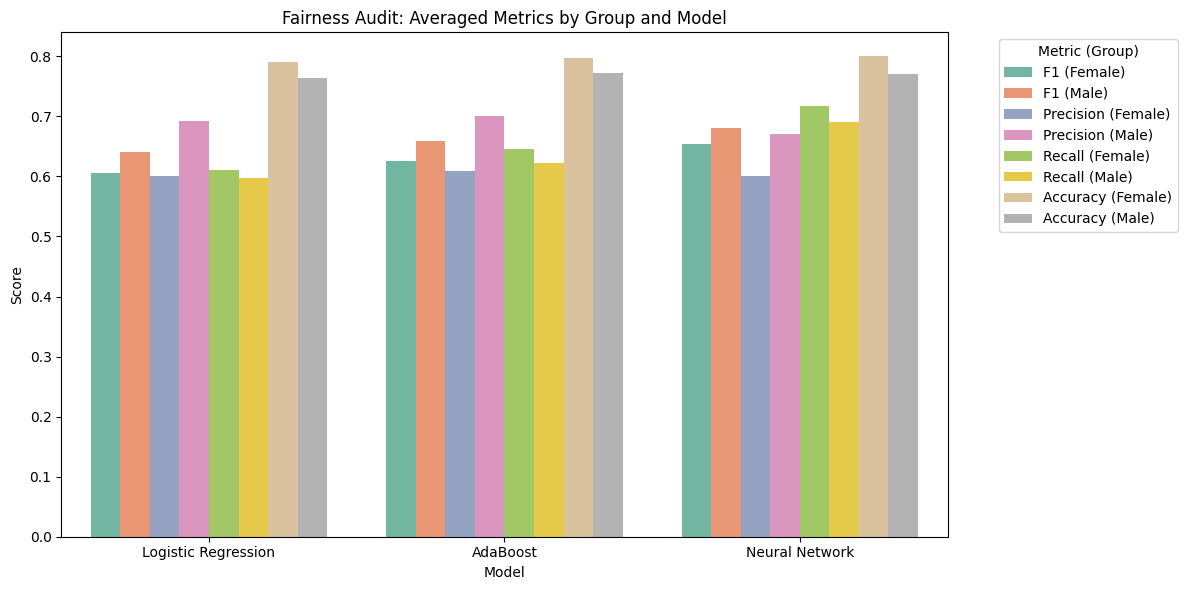

In [74]:
# Load averaged results
fairness_df = pd.read_csv("../reports/04_fairness/equalized_odds_avg_results.csv")

# Melt for visualization
melted = fairness_df.melt(id_vars=["Model", "Equalized Odds Difference"], 
                          value_vars=[
                              "F1 (Female)", "F1 (Male)",
                              "Precision (Female)", "Precision (Male)",
                              "Recall (Female)", "Recall (Male)",
                              "Accuracy (Female)", "Accuracy (Male)"
                          ],
                          var_name="MetricGroup", value_name="Score")

# Split MetricGroup into separate columns for clarity
melted[["Metric", "Group"]] = melted["MetricGroup"].str.extract(r'(\w+)\s+\((\w+)\)')

# Plot grouped bars
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x="Model", y="Score", hue="MetricGroup", palette="Set2")
plt.title("Fairness Audit: Averaged Metrics by Group and Model")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric (Group)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../reports/04_fairness/equalized_odds_avg_results_plot.png")
plt.show()

Compare results after EO postprocessing and before: 

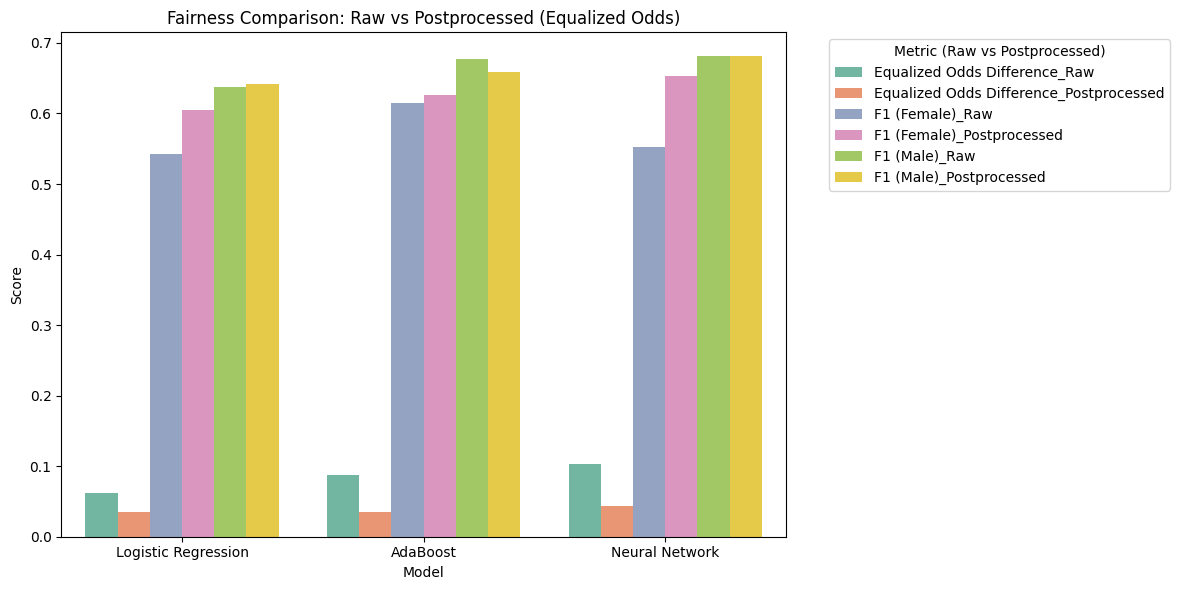

In [75]:
# Load the averaged postprocessed results
post_df = pd.read_csv("../reports/04_fairness/equalized_odds_avg_results.csv")

# Load raw model results (simulated before fairness)
raw_data = [
    {
        "Model": "Logistic Regression",
        "Equalized Odds Difference": 0.0624,
        "F1 (Female)": 0.543,
        "F1 (Male)": 0.637
    },
    {
        "Model": "AdaBoost",
        "Equalized Odds Difference": 0.0871,
        "F1 (Female)": 0.615,
        "F1 (Male)": 0.677
    },
    {
        "Model": "Neural Network",
        "Equalized Odds Difference": 0.1029,
        "F1 (Female)": 0.552,
        "F1 (Male)": 0.681
    }
]

raw_df = pd.DataFrame(raw_data)

# Merge for side-by-side comparison
comparison_df = post_df[["Model", "Equalized Odds Difference", "F1 (Female)", "F1 (Male)"]].merge(
    raw_df, on="Model", suffixes=("_Postprocessed", "_Raw")
)

# Melt for visualization
melted = comparison_df.melt(id_vars="Model", 
                            value_vars=[
                                "Equalized Odds Difference_Raw", "Equalized Odds Difference_Postprocessed",
                                "F1 (Female)_Raw", "F1 (Female)_Postprocessed",
                                "F1 (Male)_Raw", "F1 (Male)_Postprocessed"
                            ],
                            var_name="MetricType", value_name="Value")

# Split metric/group/type
melted[["Metric", "Group"]] = melted["MetricType"].str.extract(r'(.+?)_(Raw|Postprocessed)')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x="Model", y="Value", hue="MetricType", palette="Set2")
plt.title("Fairness Comparison: Raw vs Postprocessed (Equalized Odds)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric (Raw vs Postprocessed)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save
output_path = Path("../reports/04_fairness/equalized_odds_before_after_plot.png")
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path)
plt.show()